<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [0]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
df=pd.read_csv('/content/drive/My Drive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [9]:
df['reviews.text'].head()

0    I order 3 of them and one of the item is bad q...
1    Bulk is always the less expensive way to go fo...
2    Well they are not Duracell but for the price i...
3    Seem to work as well as name brand batteries a...
4    These batteries are very long lasting the pric...
Name: reviews.text, dtype: object

In [0]:
def tokenize(text):
  return[token for token in simple_preprocess(text) if token not in STOPWORDS]

In [18]:
len(df)
df.shape

(28332, 24)

In [0]:
df['reviews.tokens']=df['reviews.text'].map(tokenize)

In [0]:
for i in range(0,len(df)):
  g=tokenize(df['reviews.text'][i])
  print(g)

In [0]:
df['reviews']

In [0]:
id2word = corpora.Dictionary(df['reviews.tokens'])

In [0]:
id2word.filter_extremes(no_below=5,no_above=0.75)

In [0]:
corpus = [id2word.doc2bow(text) for text in df['reviews.tokens']]

In [0]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   num_topics=15,
                   passes=10,
                   workers=2)

In [46]:
%pprint

Pretty printing has been turned ON


In [0]:
!pip install pyldavis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [31]:
pyLDAvis.gensim.prepare(lda,corpus,id2word)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.251830 -0.007647       1        1  13.055353
14    -0.258276 -0.058982       2        1   8.780737
12    -0.037892 -0.044470       3        1   8.417235
6      0.145301  0.191876       4        1   8.308352
1     -0.229180 -0.081393       5        1   7.519649
0     -0.105880  0.029802       6        1   7.316517
5      0.143067 -0.307848       7        1   7.287061
3     -0.162781 -0.062655       8        1   5.686399
13     0.243568 -0.181184       9        1   5.152472
7     -0.122878  0.071522      10        1   5.071911
11     0.065846  0.091665      11        1   5.048376
4     -0.015751  0.033189      12        1   4.965922
9      0.068831  0.191341      13        1   4.856630
2     -0.049384 -0.010087      14        1   4.845974
8      0.063578  0.144872      15        1   3.687420, topic_info=     Category         Freq         Term        Total  loglift  logprob
21    Default  8763.000000        great  8763.000000  30.0000  30.0000
18    Default  7011.000000    batteries  7011.000000  29.0000  29.0000
2433  Default  6772.000000       tablet  6772.000000  28.0000  28.0000
17    Default  4887.000000        price  4887.000000  27.0000  27.0000
1548  Default  2139.000000         apps  2139.000000  26.0000  26.0000
23    Default  2394.000000         long  2394.000000  25.0000  25.0000
34    Default  5507.000000         good  5507.000000  24.0000  24.0000
1857  Default  2122.000000        loves  2122.000000  23.0000  23.0000
2076  Default  2955.000000       kindle  2955.000000  22.0000  22.0000
192   Default  2526.000000         kids  2526.000000  21.0000  21.0000
755   Default  2895.000000         easy  2895.000000  20.0000  20.0000
652   Default  1652.000000        games  1652.000000  19.0000  19.0000
9     Default  2230.000000         work  2230.000000  18.0000  18.0000
165   Default  2034.000000      product  2034.000000  17.0000  17.0000
521   Default  2069.000000          old  2069.000000  16.0000  16.0000
1679  Default  1618.000000       screen  1618.000000  15.0000  15.0000
90    Default  3396.000000         love  3396.000000  14.0000  14.0000
28    Default  3136.000000       bought  3136.000000  13.0000  13.0000
885   Default  1122.000000         gift  1122.000000  12.0000  12.0000
105   Default  1726.000000         year  1726.000000  11.0000  11.0000
2     Default  2033.000000      battery  2033.000000  10.0000  10.0000
96    Default  1513.000000        works  1513.000000   9.0000   9.0000
31    Default   910.000000    christmas   910.000000   8.0000   8.0000
94    Default  4402.000000          use  4402.000000   7.0000   7.0000
1268  Default   919.000000     daughter   919.000000   6.0000   6.0000
2087  Default  1445.000000        books  1445.000000   5.0000   5.0000
20    Default  1253.000000        brand  1253.000000   4.0000   4.0000
387   Default   911.000000        value   911.000000   3.0000   3.0000
1881  Default   765.000000         ipad   765.000000   2.0000   2.0000
728   Default   926.000000          son   926.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
126   Topic15    73.087875      opinion    86.235336   3.1348  -5.0445
602   Topic15   280.106018         came   376.541840   3.0044  -3.7010
187   Topic15   143.802444   convenient   186.560837   3.0399  -4.3677
490   Topic15   112.068283        handy   142.703842   3.0586  -4.6170
1162  Topic15    53.181927   interested    62.358536   3.1411  -5.3624
155   Topic15   276.896942          box   417.836121   2.8888  -3.7125
1859  Topic15    59.080521  outstanding    70.593254   3.1222  -5.2572
1739  Topic15    58.665852      waiting    71.003838   3.1094  -5.2643
692   Topic15    45.182972      receive    53.027782   3.1401  -5.5254
351   Topic15    43.022785         rate    50.287678   3.1442  -5.5744
127   Topic15   100.651947      package   151.504822   2.

In [37]:
enumerate(lda[corpus])

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


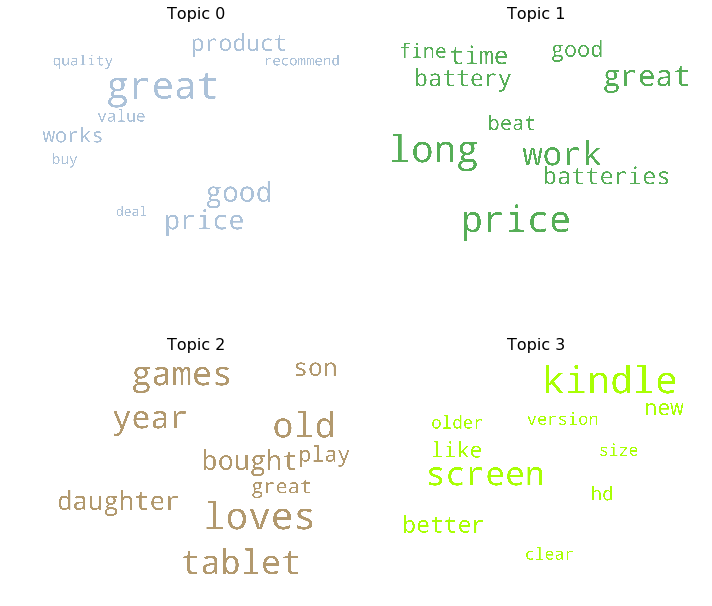

In [100]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for row_list in lda[corpus]:
  tmp=np.zeros(15)
  for i, w in row_list:
    tmp[i]=w
  topic_weights.append(tmp)

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)



In [97]:
topic_num

array([11, 10, 10, ...,  4, 12, 12])

In [99]:
len(mcolors.TABLEAU_COLORS.items())

10

In [101]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 15
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

In [91]:
np.random.rand(2,3)

array([[0.22293875, 0.52852832, 0.18047654],
       [0.48504804, 0.292781  , 0.19758491]])

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling